In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import optimize
from scipy.constants import g   

### Analytische Lösung

In [2]:
def dammbruch(x,t,x0,hl,hr,Sw):
    #Diskretisierung des Gebiets mit anfangsbedingungen
    global u2
    u2 = Sw - (g*hr)/(4*Sw)*(1+np.sqrt(1+(8*Sw**2)/(g*hr)))
    global c2
    c2 = np.sqrt((g*hr)/2*(np.sqrt(1+(8*Sw**2)/(g*hr))-1))

    h = np.zeros((len(x), len(t)), dtype= float)
    u = np.zeros((len(x), len(t)), dtype= float)

    # Randbedingungen vielleicht noch sauberer 0.5 ist 1 und 0.5 gleichzeitig
    h[:,0] = np.where(x>=x0, hr, hl)

    # Berechnung
    for i in range(1, len(t)):
        for j in range(len(x)):
            h[j,i],u[j,i] = hu(x[j],t[i])
    return h , u


# Funktionen h und u definieren
def hu(x,t):
    xa = x0 - t*np.sqrt(g*hl)
    xb = x0 + t*(u2-c2)
    xc = x0 + Sw*t
    if x < xa:
        h = hl
        u = 0
    elif xa <= x <= xb:
        h = (1/(9*g)) * (2*np.sqrt(g*hl) - (2*x - 2*x0)/(2*t))**2
        u = 2/(3*t) * (x-x0+t*(g*hl)**0.5)
    elif xb < x <= xc:
        h = hr/2 * (np.sqrt(1+((8*Sw**2)/(g*hr))) - 1)
        u = u2
    else:
        h = hr
        u = 0
    return h , u

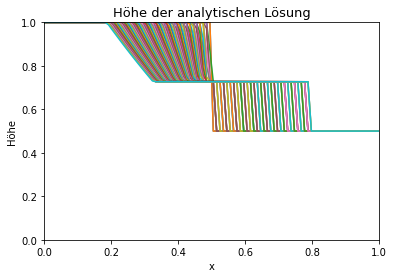

In [3]:
# Initialisierung der Werte:
hl= 1
hr = 0.5
x0 = 0.5
g= 9.81
Nx = 100
Nt = 100

#temporär: (Ersetzen mit Anfangsbedingungen, dann müsste t in Anfangsbedingungen ergänzt werden)
x = np.linspace(0, 1, Nx)
t = np.linspace(0, 0.1, Nt)


# Sw bestimmen
def f(Sw):
    return Sw - (g*hr)/(4*Sw)*(1+np.sqrt(1+(8*Sw**2)/(g*hr))) + 2*np.sqrt((g*hr)/2*(np.sqrt(1+(8*Sw**2)/(g*hr))-1)) - 2*np.sqrt(g*hl)
z = 1
while True:
    Sw = optimize.newton(f, z) # Validierung des positiven ergebnisses
    z += 1
    if Sw > 0:
        break

h,u = dammbruch(x,t,x0,hl,hr,Sw)

fig, ax = plt.subplots()
for n in range(h.shape[1]):
        ax.plot(x, h[:,n])
ax.set_xlabel('x')
ax.set_ylabel('Höhe')
ax.set_title('Höhe der analytischen Lösung')
ax.title.set_fontsize(13)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

h_ana = np.copy(h)
# Vielleicht Animation daraus machen?

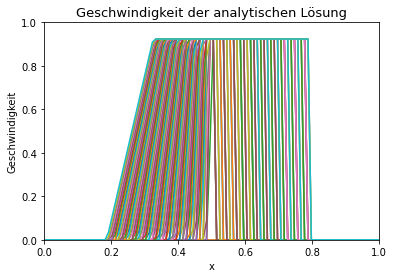

In [4]:
fig, ax = plt.subplots()
for n in range(u.shape[1]):
        ax.plot(x, u[:,n])
ax.set_xlabel('x')
ax.set_ylabel('Geschwindigkeit')
ax.set_title('Geschwindigkeit der analytischen Lösung')
ax.title.set_fontsize(13)
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

### Angenäherte Lösung

In [5]:
def erhaltungsschema(CFL, Nx, hl, hr, x0):
    g = 9.81
    x = np.linspace(0, 1, Nx)
    dx = x[1] - x[0]

    # Anfangsbedingungen
    h = np.zeros((Nx, 1), dtype= float)
    hu = np.zeros((Nx, 1), dtype= float)

    # Randbedingungen vielleicht noch sauberer 0.5 ist 1 und 0.5 gleichzeitig
    h[:,0] = np.where(x>=x0, hr, hl)

    k = 0 # Überbleibsel, wenn man mit append arbeiten möchte, wäre es einfacher k zu berhalten
    z = 0 # Zähler für zeitpunkt 0.1

    F_j12a = np.zeros((Nx-1,1),dtype= np.double)
    F_j12b = np.zeros((Nx-1,1),dtype= np.double)
    while z < 0.1:
        # Zeitschritt bestimmen (Viele berechnungen die sich doppeln)
        EV = np.array([hu[0,k]/h[0,k]-np.sqrt(g*h[0,k]), hu[0,k]/h[0,k]-np.sqrt(g*h[0,k])])
        for i in range(1,Nx):
            EV = np.append(EV,[hu[i,k]/h[i,k]-np.sqrt(g*h[i,k]), hu[i,k]/h[i,k]+np.sqrt(g*h[i,k])])
        dt = CFL * dx/(np.amax(EV))
        z += dt

    # Wände berechnen
        for j in range(0,Nx-1): # Fj ist gleich eingesetzt
            F_j12a[j,k] = 0.5*dx/dt*(h[j,k] - h[j+1,k]) + 0.5*(hu[j,k] + hu[j+1,k])
            F_j12b[j,k] = 0.5*dx/dt*(hu[j,k] - hu[j+1,k]) + 0.5 * (((hu[j,k]**2)/(h[j,k]) + 0.5*g*(h[j,k]**2)) + ((hu[j+1,k]**2)/(h[j+1,k]) + 0.5*g*(h[j+1,k]**2)))
        for l in range(1,Nx-1):
            #h[l,k+1] = (if append)
            #hu[l,k+1]
            h[l,k] = h[l,k] - dt/dx*(F_j12a[l,k] - F_j12a[l-1,k])
            hu[l,k] = hu[l,k] - (dt/dx)* (F_j12b[l,k] - F_j12b[l-1,k]) # Sj ist = 0 (Aufgabenstellung)
        # Randbedingungen reflektierend (alles k+1)
        hu[0,k] = -hu[1,k]
        hu[Nx-1,k] = -hu[Nx-2,k]
        h[0,k] = h[1,k]
        h[Nx-1,k] = h[Nx-2,k]
    return h


### Vergleich der analytischen und angenäherten Lösung

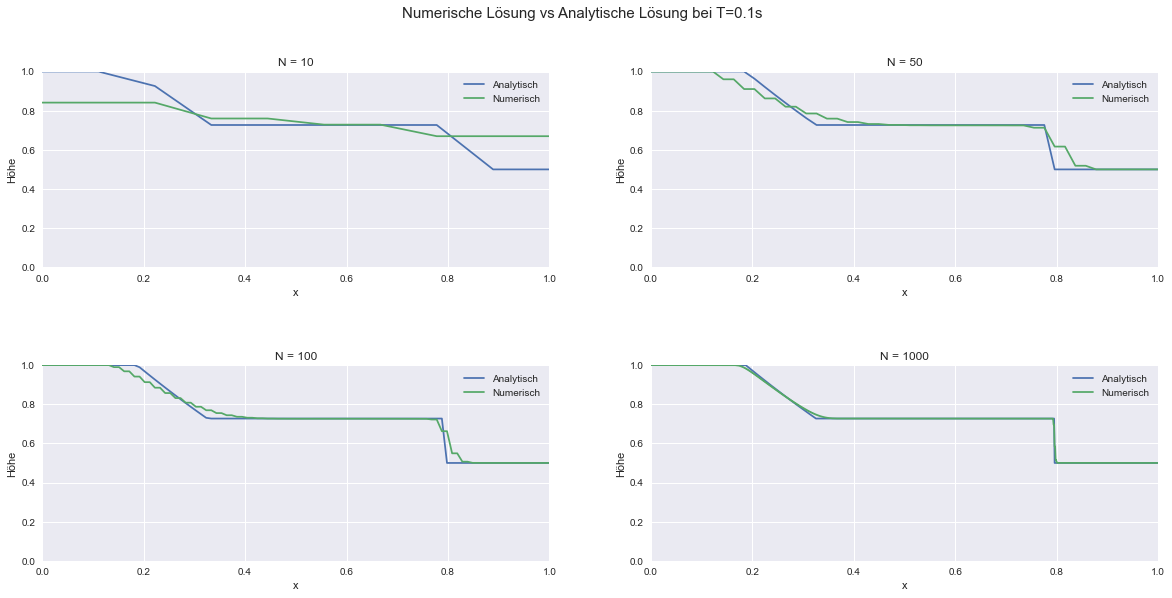

In [6]:
# Initialisierung der Werte:
hl= 1
hr = 0.5
x0 = 0.5
CFL = 1
N = [10, 50, 100, 1000]


# Plot mit verschiedenen N
plt.style.use('seaborn')

fig2, axs2 = plt.subplots(2, 2,figsize=(20, 9))
fig2.suptitle(f'Numerische Lösung vs Analytische Lösung bei T=0.1s', fontsize=15)
# fig2.suptitle(f'N = {N} CFL = {CFL}', fontsize=15)
fig2.subplots_adjust(hspace=0.5)

for i in range(len(N)):
    x = np.linspace(0, 1, N[i])
    h_ana,u = dammbruch(x,t,x0,hl,hr,Sw)
    h = erhaltungsschema(CFL, N[i], hl, hr, x0)
    
    
    axs2[i//2,i%2].plot(x, h_ana[:,-1], label='Analytisch')
    axs2[i//2,i%2].plot(x, h[:,0], label='Numerisch')
    axs2[i//2,i%2].set_xlabel('x')
    axs2[i//2,i%2].set_ylabel('Höhe')
    axs2[i//2,i%2].title.set_fontsize(13)
    axs2[i//2,i%2].set_xlim(0,1)
    axs2[i//2,i%2].set_ylim(0,1)
    axs2[i//2,i%2].set_title(f'N = {N[i]}')
    axs2[i//2,i%2].legend()
    
plt.show()
